In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
from datetime import timedelta
import random
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import time
import seaborn as sns
import math 
import os
import errno
import matplotlib.patches as patches
from matplotlib.pyplot import figure
from copy import deepcopy
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from matplotlib.patches import Ellipse, Circle
import operator
import pdb
from geopy.geocoders import Nominatim
import warnings
warnings.filterwarnings('ignore')

pd.options.mode.chained_assignment = None

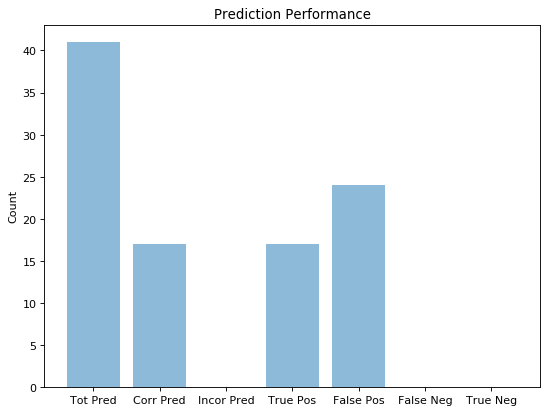

In [4]:
#Find distance between two lan:lon points in meters
def meters(lat1, lon1, lat2, lon2):  
    R = 6378.137 # Radius of earth in KM
    dLat = lat2 * math.pi / 180 - lat1 * math.pi / 180
    dLon = lon2 * math.pi / 180 - lon1 * math.pi / 180
    a = math.sin(dLat/2) * math.sin(dLat/2) + math.cos(lat1 * math.pi / 180) * math.cos(lat2 * math.pi / 180) * math.sin(dLon/2) * math.sin(dLon/2);
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a));
    d = R * c
    return d * 1000 # meters

#calculate prediction parameters
def check_pred(indx_row):
    global predic_df
    global tobepredicted_df
    global correct_pred
    global incorrect_pred
    global true_pos
    global false_pos
    global true_neg
    global false_neg

    visit_next_hour = False
    visit_count_next_hour = 0
    curr_hour = tobepredicted_df.loc[indx_row, 'Hour']
    curr_date = tobepredicted_df.loc[indx_row, 'Date']
    
    #check if there are points found in next hour
    for k in range(indx_row+1, len(tobepredicted_df)):
        
        next_hour = tobepredicted_df.loc[k, 'Hour']
        next_date = tobepredicted_df.loc[k, 'Date']
        
        if (curr_hour != next_hour) or (curr_date != next_date):
            
            if (curr_hour == 23) and (next_date == curr_date + timedelta(days=1)) and (next_hour == 0):
                visit_next_hour = True
                visit_count_next_hour = visit_count_next_hour + 1
            elif (next_date == curr_date) and (next_hour == curr_hour + 1):
                visit_next_hour = True
                visit_count_next_hour = visit_count_next_hour + 1
            else:   
                break
        
    #visit encountered in next hour: Either:
    #      A. True Positive, or
    #      B. False Negative
    if visit_next_hour == True:
        
        # B. False Negative
        if predic_df.empty:
            false_neg = false_neg + 1
        # A. True Positive
        else:
            true_pos = true_pos + 1
            
            #check if prediction is correct or incorrect
            for l in range(1, visit_count_next_hour+1):

                true_lat = tobepredicted_df['StateMeanLat'][indx_row+l]
                true_lon = tobepredicted_df['StateMeanLon'][indx_row+l]
                true_pred = False
                for i in range(0, len(predic_df)):

                    pred_lat = predic_df.loc[i, 'Latitude']
                    pred_lon = predic_df.loc[i, 'Longitude']

                    if meters(true_lat, true_lon, pred_lat, pred_lon) <= state_d_thrhld:
                        correct_pred = correct_pred + 1
                        true_pred = True
                        break

                if true_pred == True :
                    break
            
            if true_pred == False :
                    incorrect_pred = incorrect_pred + 1
                
    #visit not encountered in next hour: Either:
    #      A. False Positive, or
    #      B. True Negative
    else:
        # B. True Negative
        if predic_df.empty:
            true_neg = true_neg + 1
        # A. False Positive
        else:
            false_pos = false_pos + 1
                    
def predict():
    global trained_model_df
    global staypts_df
    global tobepredicted_df
    global predic_df
    global total_pred 
    global correct_pred
    global incorrect_pred
    global true_pos
    global false_pos
    global true_neg
    global false_neg
    
    tobepredicted_df = staypts_df[['StateId', 'StateMeanLat', 'StateMeanLon', 'Timestamp']]
    tobepredicted_df.Timestamp = pd.to_datetime(tobepredicted_df.Timestamp)
    tobepredicted_df['Date'] = tobepredicted_df['Timestamp'].dt.date
    tobepredicted_df['Hour'] =tobepredicted_df['Timestamp'].dt.hour
    tobepredicted_df = tobepredicted_df.drop(['Timestamp'], axis = 1)
    tobepredicted_df = tobepredicted_df.drop_duplicates()
    tobepredicted_df = tobepredicted_df.reset_index(drop=True)
    
    file_name = "Predictions.csv"
    file = dest_predicted_dir + file_name
    
    #remove if the file already exists
    try:
        os.remove(file)
    except OSError:
        pass
    
    for j in range(0, len(tobepredicted_df)):

        new_lat = tobepredicted_df['StateMeanLat'][j]
        new_lon = tobepredicted_df['StateMeanLon'][j]
        hour = tobepredicted_df.loc[j, 'Hour']
        
        for i in range(0, len(trained_model_df)):

            trn_lat = trained_model_df['AvgLat'][i]
            trn_lon = trained_model_df['AvgLon'][i]
            predic_df = pd.DataFrame()
            pred_made = False
            
            if meters(trn_lat, trn_lon, new_lat, new_lon) <= state_d_thrhld:
                #prediction is made
                pred_made = True
                total_pred = total_pred + 1

                cluster_id = trained_model_df['StateId'][i]
                curr_lat = trained_model_df['AvgLat'][i]
                curr_lon = trained_model_df['AvgLon'][i]
                curr_add = trained_model_df['Address'][i]
                pred_loc = {"current":(cluster_id, curr_lat, curr_lon, curr_add)}

                from_col_no = trained_model_df['StateId'].nunique() * hour + 5
                to_col_no = from_col_no + trained_model_df['StateId'].nunique()
                predic_df = trained_model_df.iloc[i:i+1,from_col_no:to_col_no]
                predic_df = predic_df.T
                predic_df['StateId'] = cluster_id
                predic_df['PredState'] = predic_df.index
                predic_df['PredState'] = predic_df['PredState'].map(lambda x: x.split('-', 2)[-1])
                predic_df.columns = ['Probability', 'StateId', 'PredState']
                
                
                #predic_df = predic_df.sort_values('Probability', ascending=False).head(10)
                predic_df = predic_df.sort_values('Probability', ascending=False)
                predic_df['DateHour'] = str(tobepredicted_df['Date'][j]) + " " + str(tobepredicted_df['Hour'][j])
                predic_df['Address'] = 0
                predic_df['Latitude'] = 0.0
                predic_df['Longitude'] = 0.0
                predic_df = predic_df.reset_index(drop=True)

                for k in range (0, len(predic_df)):
                    #import pdb; pdb.set_trace()
                    clus_to_find = int(float(predic_df['PredState'][k]))
                    add = trained_model_df.loc[ (trained_model_df['StateId'] == clus_to_find), 'Address'].values[0]
                    lat = trained_model_df.loc[ (trained_model_df['StateId'] == clus_to_find), 'AvgLat'].values[0]
                    lon = trained_model_df.loc[ (trained_model_df['StateId'] == clus_to_find), 'AvgLon'].values[0]

                    predic_df.loc[k, 'Address'] = add
                    predic_df.loc[k, 'Latitude'] = lat
                    predic_df.loc[k, 'Longitude'] = lon
                
                 
#                 print("Prediction --\n")
#                 print("Current hour - " + str(hour))
#                 print("\nPrediction\n")
#                 print(predic_df)
                
                predic_df.to_csv(file, mode = 'a')
                break
        
        #if prediction was made, calculate prediction parameters 
        if pred_made == True:
            check_pred(j)
    
    #plot parameters
    figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    objects = ('Tot Pred', 'Corr Pred', 'Incor Pred', 'True Pos', 'False Pos', 'False Neg', 'True Neg')
    y_pos = np.arange(len(objects))
    performance = [total_pred, correct_pred, incorrect_pred, true_pos, false_pos, false_neg, true_neg]
    
    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('Count')
    plt.title('Prediction Performance')
    destpng = dest_predicted_dir + "pred performance.png"
    plt.savefig(destpng)
    plt.show()
    
    #prediction parameters
    if total_pred != 0:
        acc = correct_pred / total_pred * 100
    else:
        acc = 0
        
    if true_pos + false_pos != 0:
        true_pos_rate = true_pos / (true_pos + false_neg) * 100
    else:
        true_pos_rate = 0
    
    if false_pos + true_neg != 0:
        false_pos_rate = false_pos / (false_pos + true_neg) * 100
    else:
        false_pos_rate = 0
    
    if total_pred != 0:
        acc_pos = (true_pos + true_neg) / total_pred * 100
    else:
        acc_pos = 0
    
    if true_pos + false_pos != 0:
        pos_pred_value = true_pos / (true_pos + false_pos) * 100
        false_dis_rate = false_pos / (true_pos + false_pos) * 100
    else:
        pos_pred_value = 0
        false_dis_rate = 0
    
    prediction_perf = ("Total Predictions: " + str(total_pred) + "\nCorrect Predictions: " + str(correct_pred) +
                      "\nIncorrect Predictions: " + str(incorrect_pred) +
                       "\nAccuracy%: " + str(acc) +
                      "\nTrue Positives: " + str(true_pos) + "\nFalse Positives: " + str(false_pos) +
                      "\nFalse Negatives: " + str(false_neg) + "\nTrue Negatives: " + str(true_neg) +
                      "\nTrue positive rate(Recall)%: " + str(true_pos_rate) +
                     # "\nFalse positive rate(Fall-out): " + str(false_pos_rate) +
                      "\nAccuracy Positives%: " + str(acc_pos) + 
                      "\nPositive predictive value(Precision)%: " + str(pos_pred_value) +
                      "\nFalse discovery rate%: " + str(false_dis_rate))
    text_file = dest_predicted_dir + "corr pred ratio " + str(acc) + " .txt"
    f= open(text_file,"w+")
    f.write(prediction_perf) 
    
#-----------------------------------------------------------------------------------------
train_month = "200811"
test_month = "200812"
user = "006"
state_d_thrhld = 200
src_path = "C:/Users/12sha/Documents/thesislocation/code_/stay points/v0.6 results"

trained_model_df = pd.DataFrame()
staypts_df = pd.DataFrame()
tobepredicted_df = pd.DataFrame()
predic_df = pd.DataFrame()

#staypoints file path
stay_points_file = src_path + "/User " + user + "/" + test_month + "/staypoints/staypoints.csv"
#trained model
trained_model_file = src_path + "/User " + user + "/" + train_month + "/markovchains/final.csv"
#predicted file
dest_predicted_dir = src_path + "/User " + user + "/" + test_month + "/predict/"


#counts
total_pred = 0 
correct_pred = 0
incorrect_pred = 0
true_pos = 0
false_pos = 0
true_neg = 0
false_neg = 0

trained_model_df = pd.read_csv(trained_model_file, header = 0)
staypts_df = pd.read_csv(stay_points_file, header = 0, sep = '\t')

predict()
